# Credit Card Fraud Detection

### Business and Data Understanding

**StakeHolder:** Financial Institutions

**Business Problem:** Credit card fraud is a significant issue for financial institutions, leading to substantial financial losses and customer dissatisfaction. The ability to detect and prevent fraudulent transactions is critical to protecting the financial assets of both the banks and their customers. Banks need a robust fraud detection system that can operate in real-time to minimize the impact of fraud while maintaining a positive customer experience by avoiding false positives.

**Problem Statement:** The objective of this project is to develop a machine learning model that can accurately distinguish between legitimate and fraudulent transactions using various features from transaction data. The model will focus on maximizing precision to ensure that when a transaction is flagged as fraudulent, it is highly likely to be correct. This precision-focused approach is designed to minimize the inconvenience caused by false positives, while still effectively identifying fraudulent transactions. By achieving this balance, the model will help banks reduce financial losses due to fraud and maintain high levels of customer trust and satisfaction.

#### Data Understanding:

Source: https://www.kaggle.com/datasets/kartik2112/fraud-detection

Context: 
This dataset is a simulated representation of credit card transactions, covering both legitimate and fraudulent activities. The data spans from January 1, 2019, to December 31, 2020, and includes transactions made by 1,000 customers with a pool of 800 merchants. The dataset is designed to closely mimic real-world credit card transaction patterns, making it suitable for training and evaluating fraud detection models.

Source of Simulation:
The dataset was generated using the "Sparkov Data Generation" tool, created by Brandon Harris and available on GitHub. The simulation was conducted for the specified time period, and the generated data files were subsequently combined and standardized to create a cohesive dataset.

Simulator Information:
The Sparkov Data Generation tool uses a predefined list of merchants, customers, and transaction categories. It leverages the "faker" library in Python to simulate realistic transaction data based on user-defined profiles. For example, a profile like "adults 25-50 female rural" would simulate transactions for adult females aged 25-50 living in rural areas. This profile specifies parameters such as the number of transactions per day, distribution across days of the week, and statistical properties (mean, standard deviation) for transaction amounts in various categories. The simulation process generates transactions based on these distributions, creating data that reflects the behavior of different demographic groups. The final dataset used in this project was created by generating transactions across multiple profiles and merging them to produce a more comprehensive and realistic representation of credit card transaction activity.

***Acknowledgements:***

A special thanks to Brandon Harris for developing the Sparkov Data Generation tool, which made it possible to create this simulated fraud transaction dataset. This tool provided an easy-to-use platform for generating realistic transaction data for fraud detection projects.

### Data Preparation

1. Load the Data
2. Data Cleaning
    - Assign proper dtypes to columns
    - Check for missingness and duplicates
    - Handle missing values appropriately
    - Check for outliers
    - Determine correlation matrices
3. Data Transformation
    - Standardize Data
    - One Hot Encode categorical features
4. Feature Engineering
    - City population to extra small, small, medium, large, extra large
    - Combined job types by keywords
    - Age at transaction
    - Average transaction amount
    - Unique transaction in a day
    - Transaction sequence
    - Calculate time since last transaction
    - Calculate distance between user location and merchant location

Libraries Used:
- pandas
- numpy
- sklearns
- lightgbm
- xgboost

### Modeling

- Logistic Regression
- XGBoost
- LightGBM
- Random Forest
- Support Vector Machines

### Evaluation

Final Model: XGBoost

- Training Precision Score: 0.9985, Test Precision Score: 0.9875
- Training Recall Score: 0.9985, Test Recall Score: 0.9858
- Training F1 Score: 0.9985, Test F1 Score: 0.9867

## Import Dataset

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, precision_score, recall_score, f1_score, classification_report, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('../data/raw/fraudTrain.csv')

## A look into the data

In [4]:
train

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,...,37.7175,-112.4777,258,Geoscientist,1961-11-24,440b587732da4dc1a6395aba5fb41669,1371816728,36.841266,-111.690765,0
1296671,1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,...,39.2667,-77.5101,100,"Production assistant, television",1979-12-11,278000d2e0d2277d1de2f890067dcc0a,1371816739,38.906881,-78.246528,0
1296672,1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,...,32.9396,-105.8189,899,Naval architect,1967-08-30,483f52fe67fabef353d552c1e662974c,1371816752,33.619513,-105.130529,0
1296673,1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,...,43.3526,-102.5411,1126,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.241160,0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [6]:
train.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,6.483370e+05,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03
std,3.743180e+05,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00
25%,3.241685e+05,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00
50%,6.483370e+05,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00
75%,9.725055e+05,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00
max,1.296674e+06,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00


## Cleaning the data

In [7]:
train.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [8]:
# drop unnecessary columns for data analysis
train.drop(['Unnamed: 0', 'first', 'last'], inplace=True, axis=1)

In [9]:
# check for missing values
train.isnull().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [10]:
# check for duplicates
train.duplicated().sum()

0

In [11]:
# Split the 'trans_date_trans_time' column into 'trans_date'
train[['trans_date']] = train['trans_date_trans_time'].str.split(' ', expand=True)[0]

train['trans_date_trans_time'] = pd.to_datetime(train['trans_date_trans_time'])
train['dob'] = pd.to_datetime(train['dob'])
train['trans_date'] = pd.to_datetime(train['trans_date'])

train['trans_day'] = train['trans_date_trans_time'].dt.day
train['trans_month'] = train['trans_date_trans_time'].dt.month
train['trans_year'] = train['trans_date_trans_time'].dt.year
train['trans_hour'] = train['trans_date_trans_time'].dt.hour

In [12]:
# calculate age of the customer
train['age_at_transaction'] = (train['trans_date'] - train['dob']).dt.days // 365

In [13]:
# remove 'fraud_' from merchant column
train['merchant'] = train['merchant'].str.replace('fraud_', '')

**Review**

The dataset doesn't have any missing values or duplicates. The dataset did have wrong datetime types. I featured engineered the age_at_transaction column to determine how old the person was at the time of tranaction. I also removed "fraud_" from the merchant column to get a cleaner name of each merchant. Overall, there wasn't much to clean with this dataset.

# Outlier Detection

In [14]:
numerical_columns = ['amt', 'city_pop', 'unix_time', 'age_at_transaction']

In [15]:
# function to plot outliers
def plot_outlier(df, col):
    plt.figure(figsize=(20, 10))
    for i, col in enumerate(numerical_columns):
        plt.subplot(1, 4, i + 1)
        sns.boxplot(df[col])
        plt.title(col)
        plt.xlabel(col)

    plt.show()

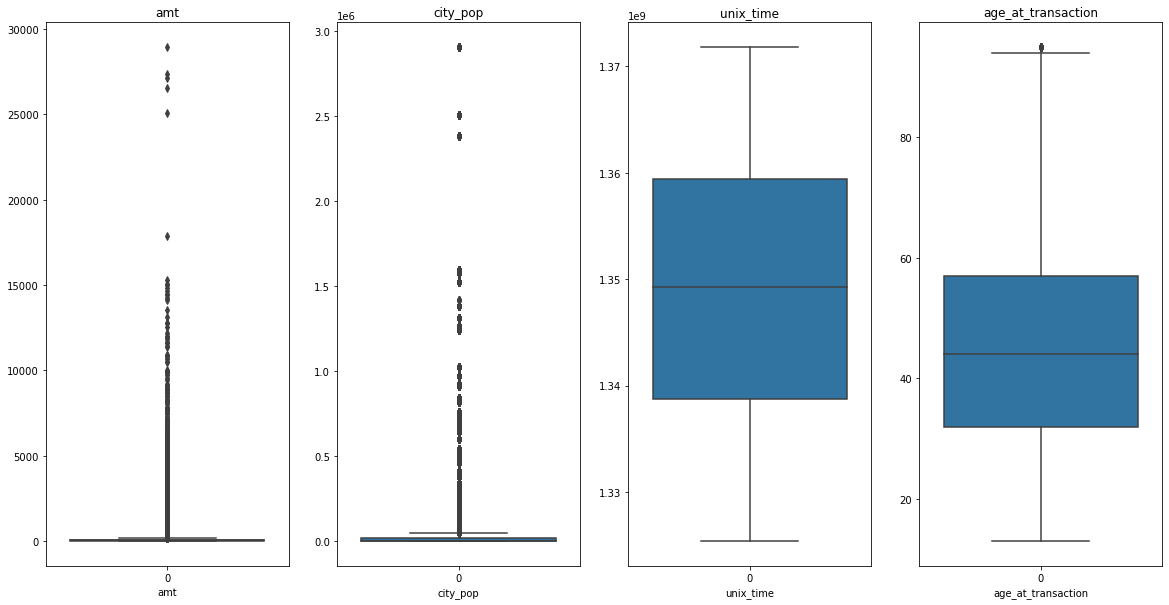

In [16]:
# find outlier in numerical columns in train data
plot_outlier(train, numerical_columns)

**Review**

Since our goal is to identify fradulent credit card transaction, outliers could potentially play a crucial role. The outliers found could be those fraud payments. Therefore, all outliers will be kept to further examine the nature of outliers and how they relate to fraud.

## Correlation Matrices

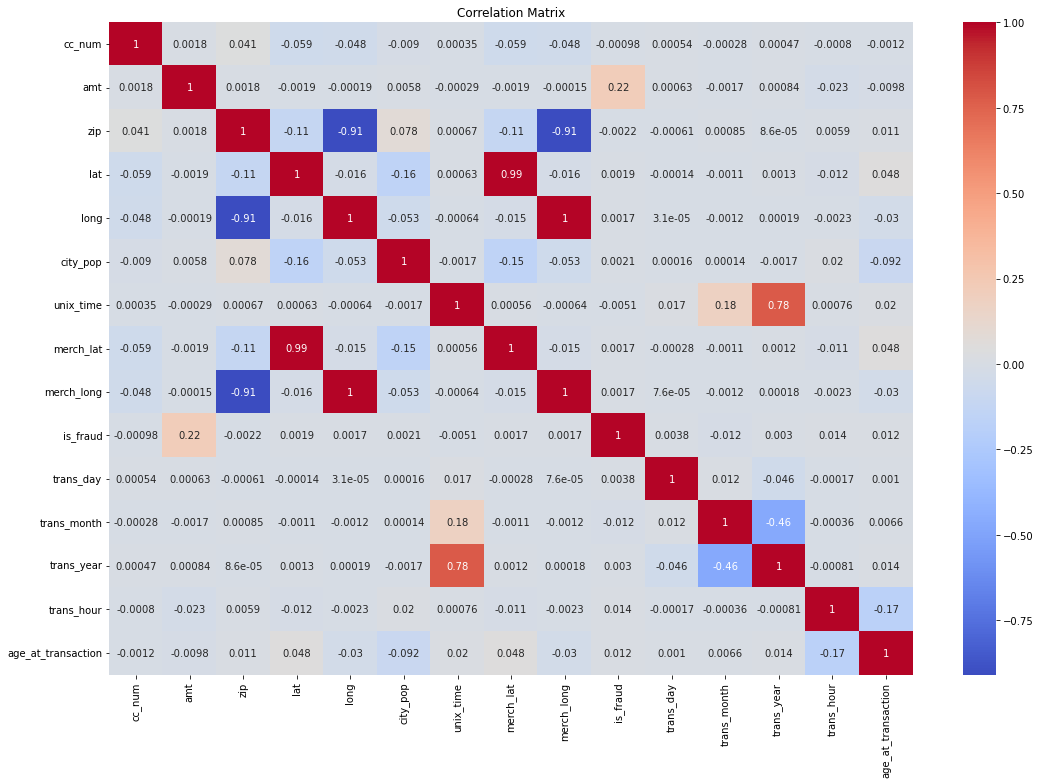

In [17]:
# plot correlation matrix
plt.figure(figsize=(18, 12))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Data Visualization

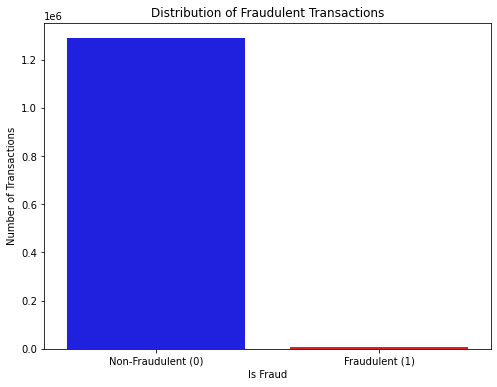

In [18]:
# Count the number of occurrences of each unique value in the 'is_fraud' column
fraud_counts = train['is_fraud'].value_counts().reset_index()
fraud_counts.columns = ['is_fraud', 'count']

# Plotting using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='is_fraud', y='count', data=fraud_counts, palette=['blue', 'red'])
plt.title('Distribution of Fraudulent Transactions')
plt.xlabel('Is Fraud')
plt.ylabel('Number of Transactions')
plt.xticks(ticks=[0, 1], labels=['Non-Fraudulent (0)', 'Fraudulent (1)'])
plt.show()

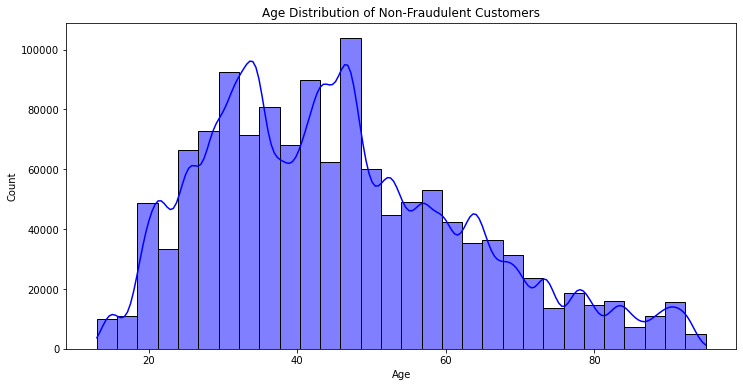

In [19]:
# plot age of non-fraudulent customers in blue
plt.figure(figsize=(12, 6))
sns.histplot(train[train['is_fraud'] == 0]['age_at_transaction'], bins=30, color='blue', kde=True)
plt.title('Age Distribution of Non-Fraudulent Customers')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

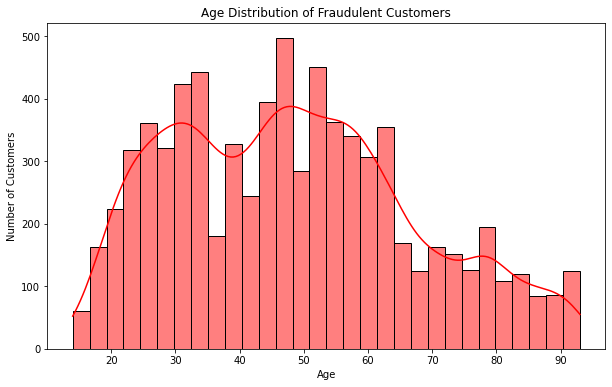

In [20]:
# plot age of fraud customers in red
plt.figure(figsize=(10, 6))
sns.histplot(train[train['is_fraud'] == 1]['age_at_transaction'], bins=30, color='red', kde=True)
plt.title('Age Distribution of Fraudulent Customers')
plt.xlabel('Age')
plt.ylabel('Number of Customers')
plt.show()

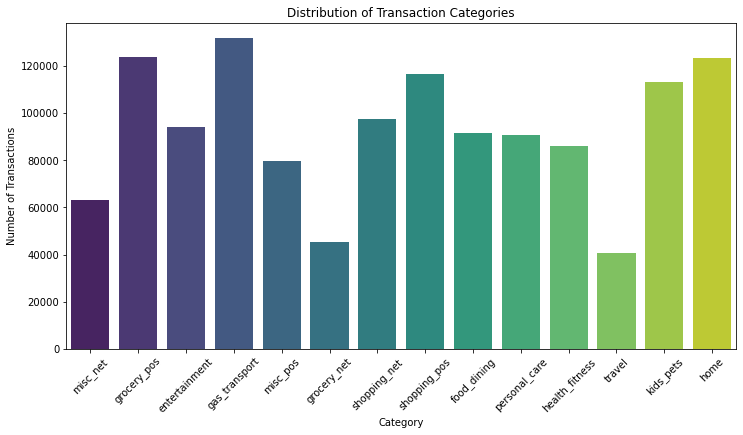

In [21]:
# plot different number of categories
plt.figure(figsize=(12, 6))
sns.countplot(x='category', data=train, palette='viridis')
plt.title('Distribution of Transaction Categories')
plt.xlabel('Category')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()

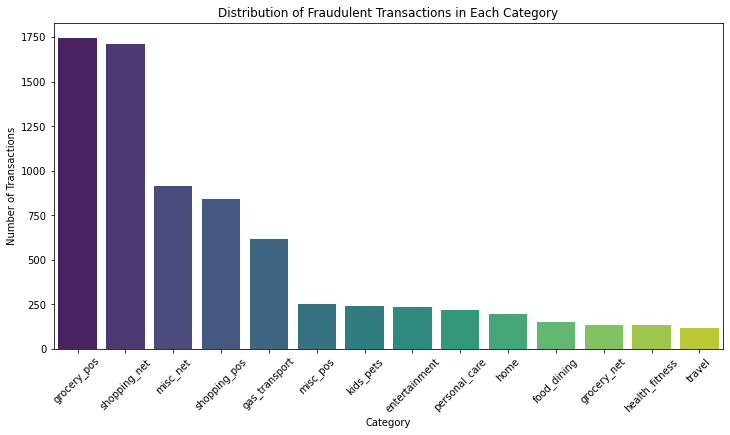

In [22]:
# plot the number of fraudulent transactions in each category sorted from highest to lowest
plt.figure(figsize=(12, 6))
sns.countplot(x='category', data=train[train['is_fraud'] == 1], palette='viridis', order=train[train['is_fraud'] == 1]['category'].value_counts().index)
plt.title('Distribution of Fraudulent Transactions in Each Category')
plt.xlabel('Category')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()

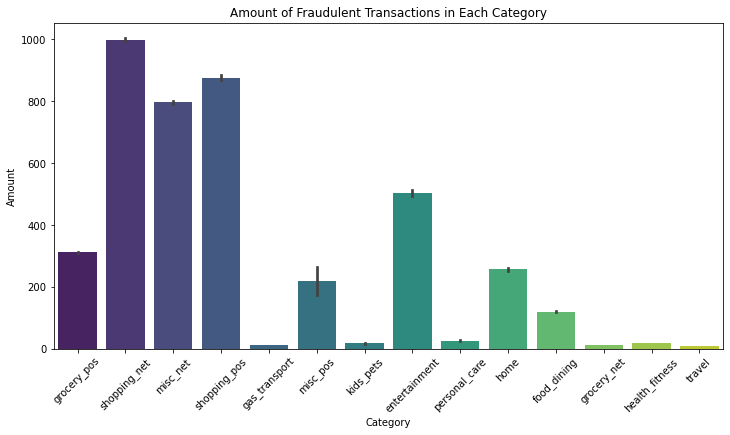

In [23]:
# plot the amount of fraudulent transaction sorted from highest to lowest
plt.figure(figsize=(12, 6))
sns.barplot(x='category', y='amt', data=train[train['is_fraud'] == 1], palette='viridis', order=train[train['is_fraud'] == 1]['category'].value_counts().index)
plt.title('Amount of Fraudulent Transactions in Each Category')
plt.xlabel('Category')
plt.ylabel('Amount')
plt.xticks(rotation=45)
plt.show()

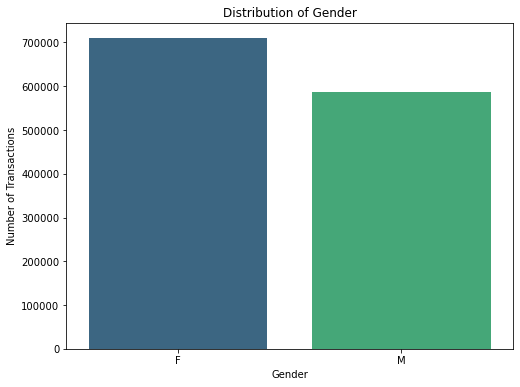

In [24]:
# plot gender distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', data=train, palette='viridis')
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Transactions')
plt.show()

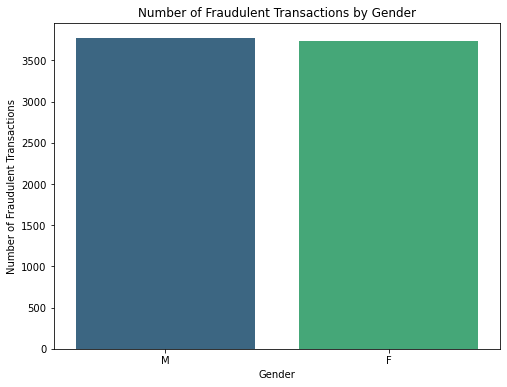

In [25]:
fraud_counts = train[train['is_fraud'] == 1]
fraud_counts_by_gender = fraud_counts['gender'].value_counts().reset_index()
fraud_counts_by_gender.columns = ['gender', 'count']

# plot fraud transactions by gender
plt.figure(figsize=(8, 6))
sns.barplot(x='gender', y='count', data=fraud_counts_by_gender, palette='viridis')
plt.title('Number of Fraudulent Transactions by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()

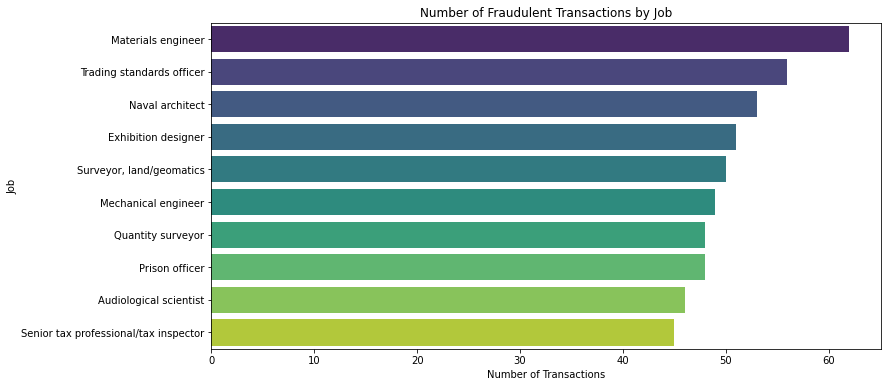

In [26]:
# plot fraud transactions by job (top 10)
plt.figure(figsize=(12, 6))
sns.countplot(y='job', data=train[train['is_fraud'] == 1], palette='viridis', order=train[train['is_fraud'] == 1]['job'].value_counts().index[:10])
plt.title('Number of Fraudulent Transactions by Job')
plt.xlabel('Number of Transactions')
plt.ylabel('Job')
plt.show()

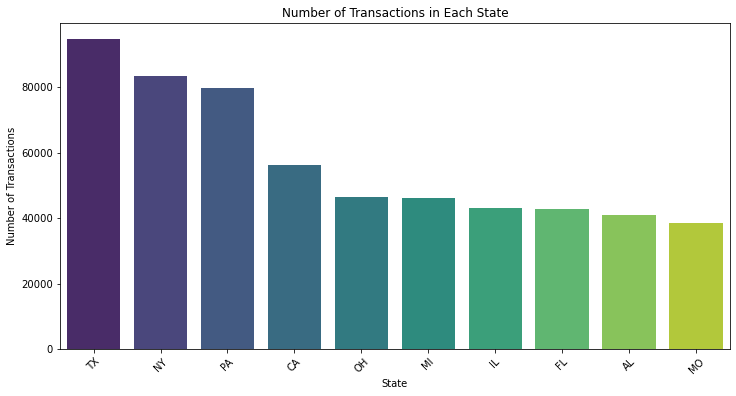

In [27]:
# graph a map of the United States with the number of transactions in each state
plt.figure(figsize=(12, 6))
sns.countplot(x='state', data=train, palette='viridis', order=train['state'].value_counts().index[:10])
plt.title('Number of Transactions in Each State')
plt.xlabel('State')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()

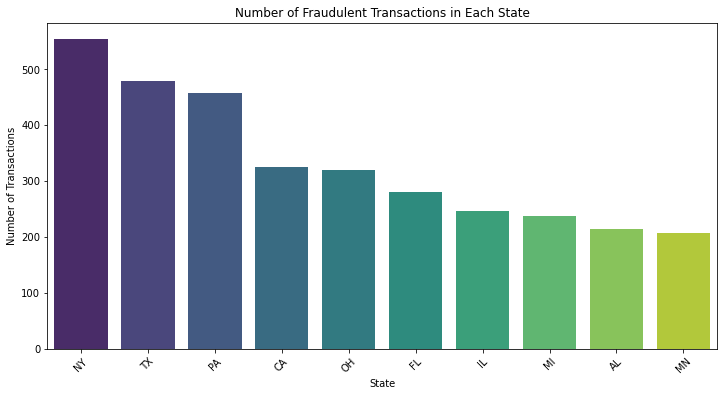

In [28]:
# graph a map of the United States with the number of fraudulent transactions in each state
plt.figure(figsize=(12, 6))
sns.countplot(x='state', data=train[train['is_fraud'] == 1], palette='viridis', order=train[train['is_fraud'] == 1]['state'].value_counts().index[:10])
plt.title('Number of Fraudulent Transactions in Each State')
plt.xlabel('State')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()

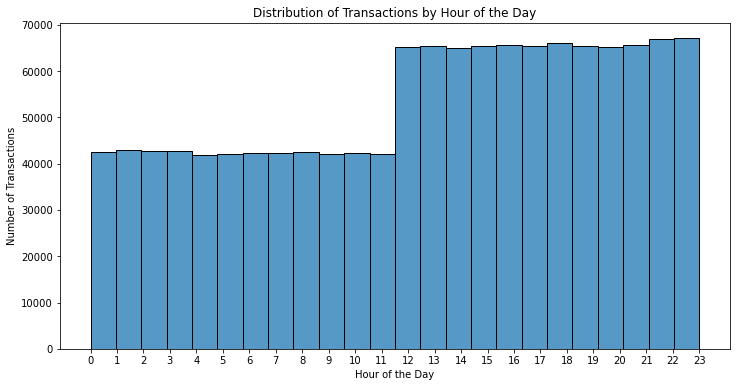

In [29]:
# what time of the day do most transactions occur
train['trans_hour'] = train['trans_date_trans_time'].dt.hour

plt.figure(figsize=(12, 6))
sns.histplot(train['trans_hour'], bins=24, kde=False)
plt.title('Distribution of Transactions by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Transactions')
plt.xticks(range(0, 24))
plt.show()

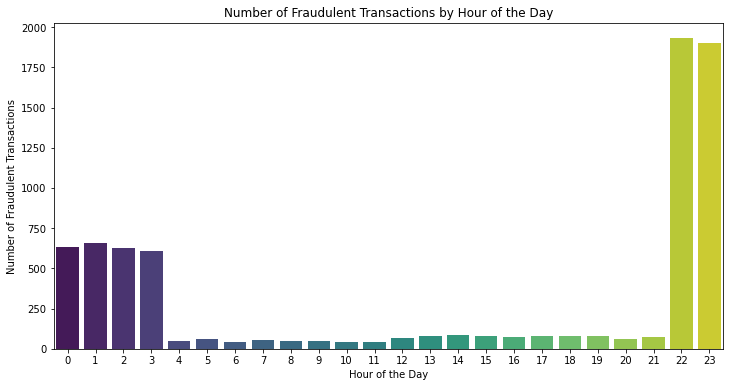

In [30]:
# what time of the day do most fraudulent transactions occur
fraud_counts['trans_hour'] = fraud_counts['trans_date_trans_time'].dt.hour

plt.figure(figsize=(12, 6))
sns.countplot(x='trans_hour', data=fraud_counts, palette='viridis')
plt.title('Number of Fraudulent Transactions by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(range(0, 24))
plt.show()

## Preprocessing Dataset

In [31]:
# divide city population into extra small, small, medium, large, and extra large
def city_pop_group(pop):
    if pop < 10000:
        return 'extra small'
    elif pop < 100000:
        return 'small'
    elif pop < 500000:
        return 'medium'
    elif pop < 1000000:
        return 'large'
    else:
        return 'extra large'
    
# apply the function to the 'city_pop' column
train['city_pop_group'] = train['city_pop'].apply(city_pop_group)

In [32]:
# Define keywords for each category
job_keywords = {
    'technology': ['engineer', 'technologist', 'programmer', 'developer', 'architect'],
    'medical': ['nurse', 'doctor', 'therapist', 'pharmacist', 'scientist', 'surgeon'],
    'education': ['teacher', 'professor', 'lecturer', 'researcher', 'educator'],
    'media and design': ['designer', 'artist', 'writer', 'journalist', 'musician'],
    'business': ['manager', 'executive', 'consultant', 'officer', 'accountant'],
    'law and public service': ['lawyer', 'solicitor', 'officer', 'police', 'firefighter', 'judge'],
    'science': ['scientist', 'biologist', 'chemist', 'ecologist', 'researcher'],
    'transportation': ['logistics', 'transport', 'driver', 'pilot', 'coordinator'],
    'agriculture and rural affairs': ['farmer', 'agricultural', 'veterinary', 'horticulturist'],
    'construction': ['architect', 'builder', 'surveyor', 'contractor', 'civil engineer'],
}

# Function to categorize job titles
def categorize_job(title):
    title = title.lower()  # Convert the job title to lowercase for easier matching
    for category, keywords in job_keywords.items():
        if any(re.search(r'\b' + keyword + r'\b', title) for keyword in keywords):
            return category
    return 'other'

In [33]:
train['job_category'] = train['job'].apply(categorize_job)

In [34]:
# calculate the time since last transaction
train = train.sort_values(by=['cc_num', 'trans_date_trans_time'])
train['time_since_last_trans'] = train.groupby('cc_num')['trans_date_trans_time'].diff().dt.total_seconds().fillna(0)

In [35]:
# Calculate average transaction amount and deviation
train['avg_transaction_amount'] = train.groupby('cc_num')['amt'].transform('mean')
# train['transaction_amount_deviation'] = train['amt'] - train['avg_transaction_amount']

In [36]:
# # Merchant and category count
# train['merchant_transaction_count'] = train.groupby(['cc_num', 'merchant'])['trans_num'].transform('count')
train['category_transaction_count'] = train.groupby(['cc_num', 'category'])['trans_num'].transform('count')

In [37]:
# Unique transactions per day
train['unique_transactions_day'] = train.groupby(['cc_num', train['trans_date_trans_time'].dt.date])['trans_num'].transform('nunique')

In [38]:
# Frequency of transactions
train['transaction_sequence'] = train.groupby('cc_num').cumcount() + 1

In [39]:
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 3956  # Radius of Earth in kilometers. Use 3956 for miles.
    return c * r

In [40]:
user_lat, user_long = train['lat'], train['long']
merch_lat, merch_long = train['merch_lat'], train['merch_long']

# Calculate distance between user location and merchant location
train['user_merchant_distance'] = haversine(user_lat, user_long, merch_lat, merch_long)

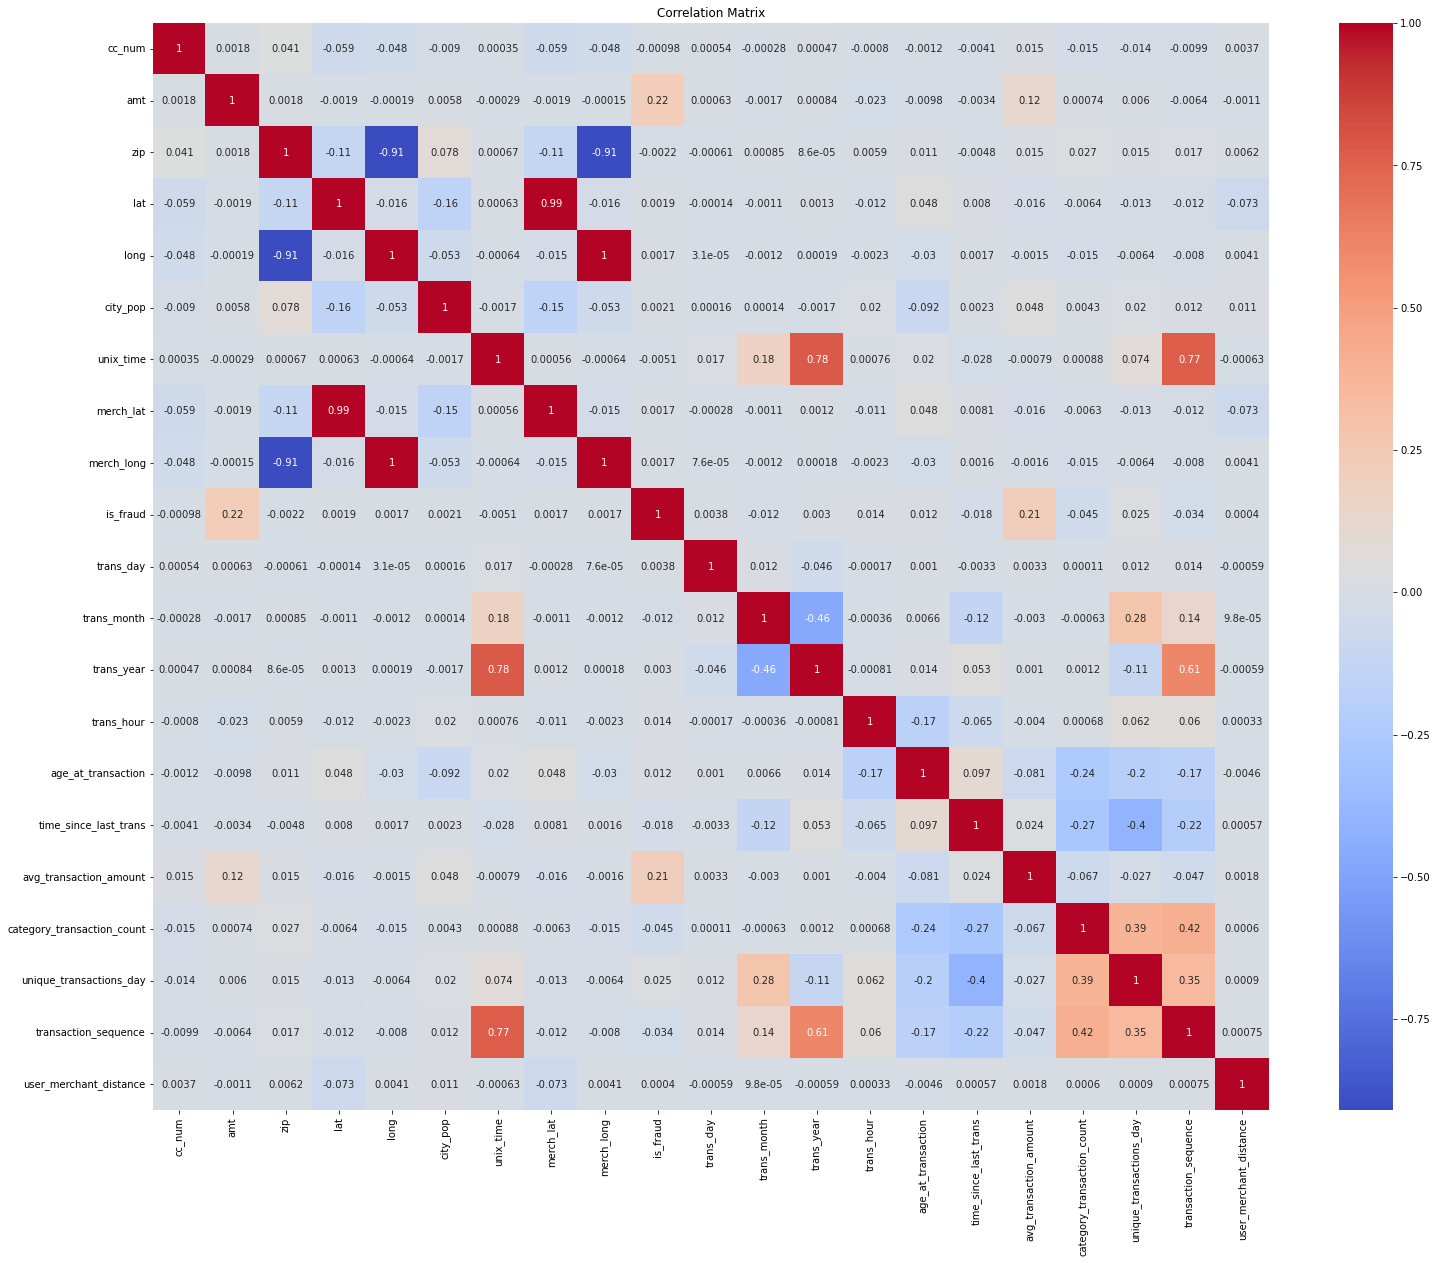

In [41]:
# correalation matrix
plt.figure(figsize=(25, 20))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [42]:
train.drop(columns=[ "lat", "long", "merch_lat", 'merch_long', 'trans_year', 'unix_time', 'trans_num', 'trans_date_trans_time', 'cc_num', 'dob', 'merchant', 'street', 'city', 'dob', 'gender', 'trans_date'], inplace=True)

In [43]:
train.drop(columns=['city_pop', 'job', 'transaction_sequence'], inplace=True)

In [44]:
# how many fraud transactions are there in the data
train['is_fraud'].value_counts()

0    1289169
1       7506
Name: is_fraud, dtype: int64

In [45]:
train

,category,amt,state,zip,is_fraud,trans_day,trans_month,trans_hour,age_at_transaction,city_pop_group,job_category,time_since_last_trans,avg_transaction_amount,category_transaction_count,unique_transactions_day,user_merchant_distance
1017,misc_net,7.27,WY,82514,0,1,1,12,32,extra small,business,0.0,56.023366,73,1,79.235643
2724,gas_transport,52.94,WY,82514,0,2,1,8,32,extra small,business,71862.0,56.023366,223,4,68.495070
2726,gas_transport,82.08,WY,82514,0,2,1,8,32,extra small,business,159.0,56.023366,223,4,13.528552
2882,kids_pets,34.79,WY,82514,0,2,1,12,32,extra small,business,13838.0,56.023366,120,4,54.148466
2907,home,27.18,WY,82514,0,2,1,13,32,extra small,business,1952.0,56.023366,142,4,46.081697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1294934,personal_care,60.47,IL,61335,0,20,6,21,64,extra small,medical,30740.0,67.843832,148,4,48.739064
1295369,gas_transport,74.29,IL,61335,0,21,6,0,64,extra small,medical,12962.0,67.843832,298,4,34.400477
1295587,shopping_net,246.56,IL,61335,0,21,6,2,64,extra small,medical,7618.0,67.843832,164,4,71.826703
1296206,shopping_pos,2.62,IL,61335,0,21,6,8,64,extra small,medical,18989.0,67.843832,145,4,37.575106


In [46]:
# sample 7506 non-fraud transactions
non_fraud = train[train['is_fraud'] == 0].sample(7506, random_state=42)

# take all fraud transactions
fraud = train[train['is_fraud'] == 1]

# combine the two samples
train_sample = pd.concat([non_fraud, fraud])

In [47]:
X = train_sample.drop('is_fraud', axis=1)
y = train_sample['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [48]:
# Identify numerical and categorical columns
numerical_cols = ['amt', 'trans_day', 'trans_month', 'trans_hour', 'age_at_transaction', 
                  'time_since_last_trans', 'avg_transaction_amount', 'category_transaction_count', 
                  'unique_transactions_day', 'user_merchant_distance']

categorical_cols = ['category', 'state', 'city_pop_group', 'job_category']

In [49]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

In [50]:
def run_grid_search(model_pipeline, param_grid, model_name):
    # Perform grid search with precision as the scoring metric
    grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='precision', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    
    # Predict probabilities
    y_train_pred = best_model.predict_proba(X_train)[:, 1]
    y_test_pred = best_model.predict_proba(X_test)[:, 1]
    
    # Convert probabilities to binary predictions using a threshold of 0.5
    y_train_pred_class = (y_train_pred > 0.5).astype(int)
    y_test_pred_class = (y_test_pred > 0.5).astype(int)
    
    # Evaluation metrics
    train_precision = precision_score(y_train, y_train_pred_class)
    test_precision = precision_score(y_test, y_test_pred_class)
    train_recall = recall_score(y_train, y_train_pred_class)
    test_recall = recall_score(y_test, y_test_pred_class)
    train_f1 = f1_score(y_train, y_train_pred_class)
    test_f1 = f1_score(y_test, y_test_pred_class)
    roc_auc = roc_auc_score(y_test, y_test_pred)
    classification_rep = classification_report(y_test, y_test_pred_class)
    
    # Print metrics
    print(f"{model_name} - Best Parameters: {grid_search.best_params_}")
    print(f"Training Precision Score: {train_precision}, Test Precision Score: {test_precision}")
    print(f"Training Recall Score: {train_recall}, Test Recall Score: {test_recall}")
    print(f"Training F1 Score: {train_f1}, Test F1 Score: {test_f1}")
    print(f"ROC AUC Score: {roc_auc}")
    print(f"Classification Report:\n{classification_rep}\n")
    
    # Confusion Matrix
    ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, display_labels=['Not Fraud', 'Fraud'])
    plt.title(f"Confusion Matrix ({model_name})")
    plt.show()
    
    # Combined ROC Curve (Train and Test)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    
    plt.figure()
    plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='Train ROC curve (area = %0.2f)' % roc_auc_score(y_train, y_train_pred))
    plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='Test ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({model_name})')
    plt.legend(loc="lower right")
    plt.show()

    return best_model

## Model Building

In [51]:
baseline_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

Logistic Regression - Best Parameters: {}
Training Precision Score: 0.9076891018962284, Test Precision Score: 0.910948905109489
Training Recall Score: 0.829082603730491, Test Recall Score: 0.8312611012433393
Training F1 Score: 0.8666069829901523, Test F1 Score: 0.8692825632690968
ROC AUC Score: 0.938525928403093
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      2252
           1       0.91      0.83      0.87      2252

    accuracy                           0.88      4504
   macro avg       0.88      0.88      0.87      4504
weighted avg       0.88      0.88      0.87      4504




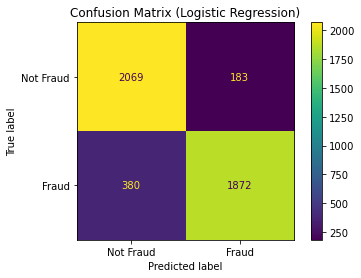

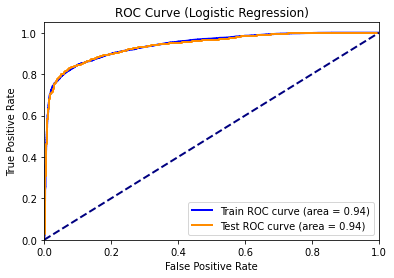

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amt', 'trans_day',
                                                   'trans_month', 'trans_hour',
                                                   'age_at_transaction',
                                                   'time_since_last_trans',
                                                   'avg_transaction_amount',
                                                   'category_transaction_count',
                                                   'unique_transactions_day',
                                                   'user_merchant_distance']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['category', 'state',
                                                   'city_pop_group',
                                                   'job_category'])])),
                ('classifier', LogisticRegression(random_state=42))])

In [52]:
baseline = run_grid_search(baseline_pipeline, {}, 'Logistic Regression')
baseline

### Logistic Regression

In [53]:
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

logistic_param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga'],
}

Logistic Regression - Best Parameters: {'classifier__C': 0.01, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Training Precision Score: 0.9426324311820495, Test Precision Score: 0.9400107123727905
Training Recall Score: 0.775599543205177, Test Recall Score: 0.7793072824156305
Training F1 Score: 0.8509971807455362, Test F1 Score: 0.852148579752367
ROC AUC Score: 0.9170695714722892
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.95      0.88      2252
           1       0.94      0.78      0.85      2252

    accuracy                           0.86      4504
   macro avg       0.88      0.86      0.86      4504
weighted avg       0.88      0.86      0.86      4504




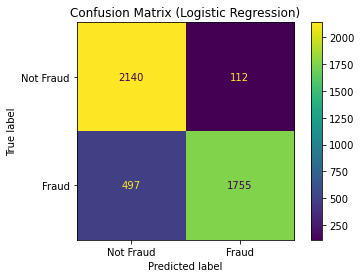

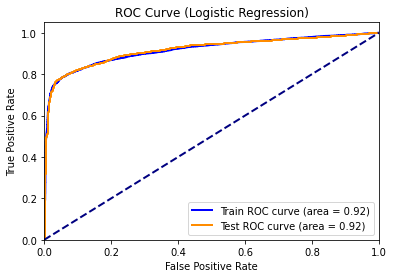

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amt', 'trans_day',
                                                   'trans_month', 'trans_hour',
                                                   'age_at_transaction',
                                                   'time_since_last_trans',
                                                   'avg_transaction_amount',
                                                   'category_transaction_count',
                                                   'unique_transactions_day',
                                                   'user_merchant_distance']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['category', 'state',
                                                   'city_pop_group',
                                                   'job_category'])])),
                ('classifier',
                 LogisticRegression(C=0.01, penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [54]:
logistic_regression = run_grid_search(logistic_pipeline, logistic_param_grid, "Logistic Regression")
logistic_regression

### XGBoost

In [55]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42))
])

xgb_param_grid = {
    'classifier__n_estimators': [50, 100, 150], 
    'classifier__max_depth': [2, 3, 4], 
    'classifier__learning_rate': [0.01, 0.1, 0.2], 
    'classifier__subsample': [0.6, 0.8], 
}

XGBoost - Best Parameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 4, 'classifier__n_estimators': 150, 'classifier__subsample': 0.8}
Training Precision Score: 0.9984761904761905, Test Precision Score: 0.9866607381058248
Training Recall Score: 0.9977160258850399, Test Recall Score: 0.9853463587921847
Training F1 Score: 0.9980959634424982, Test F1 Score: 0.9860031104199066
ROC AUC Score: 0.9985112897475779
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2252
           1       0.99      0.99      0.99      2252

    accuracy                           0.99      4504
   macro avg       0.99      0.99      0.99      4504
weighted avg       0.99      0.99      0.99      4504




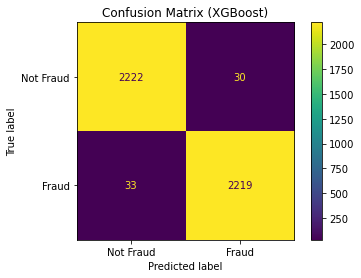

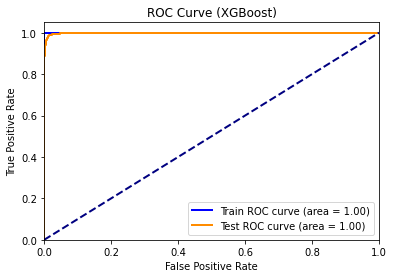

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amt', 'trans_day',
                                                   'trans_month', 'trans_hour',
                                                   'age_at_transaction',
                                                   'time_since_last_trans',
                                                   'avg_transaction_amount',
                                                   'category_transaction_count',
                                                   'unique_transactions_day',
                                                   'user_merchant_distance']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['category', 'state...
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.2,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=150,
                               n_jobs=0, num_parallel_tree=1, random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.8, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [56]:
xgboost = run_grid_search(xgb_pipeline, xgb_param_grid, "XGBoost")
xgboost

### LightGBM

In [57]:
# LightGBM Model
lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(random_state=42, verbose=-1))
])

lgbm_param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__subsample': [0.6, 0.8],
}

LightGBM - Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 150, 'classifier__subsample': 0.6}
Training Precision Score: 0.9984753192300362, Test Precision Score: 0.984472049689441
Training Recall Score: 0.9971450323562999, Test Recall Score: 0.9853463587921847
Training F1 Score: 0.9978097324064374, Test F1 Score: 0.9849090102086108
ROC AUC Score: 0.9985010363789519
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2252
           1       0.98      0.99      0.98      2252

    accuracy                           0.98      4504
   macro avg       0.98      0.98      0.98      4504
weighted avg       0.98      0.98      0.98      4504




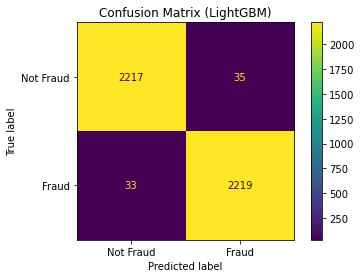

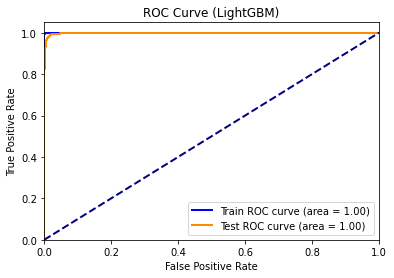

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amt', 'trans_day',
                                                   'trans_month', 'trans_hour',
                                                   'age_at_transaction',
                                                   'time_since_last_trans',
                                                   'avg_transaction_amount',
                                                   'category_transaction_count',
                                                   'unique_transactions_day',
                                                   'user_merchant_distance']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['category', 'state',
                                                   'city_pop_group',
                                                   'job_category'])])),
                ('classifier',
                 LGBMClassifier(max_depth=5, n_estimators=150, random_state=42,
                                subsample=0.6, verbose=-1))])

In [58]:
lightgbm = run_grid_search(lgbm_pipeline, lgbm_param_grid, "LightGBM")
lightgbm

### Random Forest

In [59]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

rf_param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [3, 5, 7],
    'classifier__min_samples_split': [3, 5, 8],
    'classifier__min_samples_leaf': [3, 5, 8],
}

Random Forest - Best Parameters: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 8, 'classifier__n_estimators': 50}
Training Precision Score: 0.9675138121546961, Test Precision Score: 0.9604925602873269
Training Recall Score: 0.8332698896079178, Test Recall Score: 0.8312611012433393
Training F1 Score: 0.8953880764904388, Test F1 Score: 0.8912163770530825
ROC AUC Score: 0.9732516231871255
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.97      0.90      2252
           1       0.96      0.83      0.89      2252

    accuracy                           0.90      4504
   macro avg       0.91      0.90      0.90      4504
weighted avg       0.91      0.90      0.90      4504




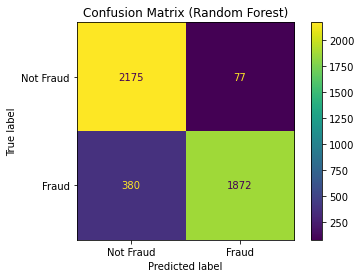

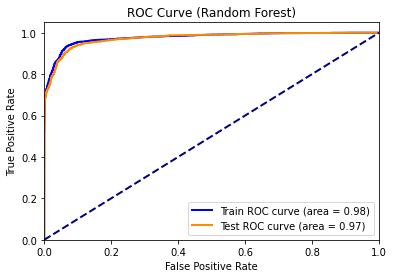

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amt', 'trans_day',
                                                   'trans_month', 'trans_hour',
                                                   'age_at_transaction',
                                                   'time_since_last_trans',
                                                   'avg_transaction_amount',
                                                   'category_transaction_count',
                                                   'unique_transactions_day',
                                                   'user_merchant_distance']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['category', 'state',
                                                   'city_pop_group',
                                                   'job_category'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=5, min_samples_leaf=3,
                                        min_samples_split=8, n_estimators=50,
                                        random_state=42))])

In [60]:
random_forest = run_grid_search(rf_pipeline, rf_param_grid, "Random Forest")
random_forest

### Support Vector Machines (SVM)

In [61]:
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, random_state=42))
])

svm_param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto'],
}

SVM - Best Parameters: {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Training Precision Score: 0.9322895485969906, Test Precision Score: 0.9395973154362416
Training Recall Score: 0.8726684430909784, Test Recall Score: 0.8703374777975134
Training F1 Score: 0.901494298073142, Test F1 Score: 0.9036422314430613
ROC AUC Score: 0.959893948619581
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2252
           1       0.94      0.87      0.90      2252

    accuracy                           0.91      4504
   macro avg       0.91      0.91      0.91      4504
weighted avg       0.91      0.91      0.91      4504




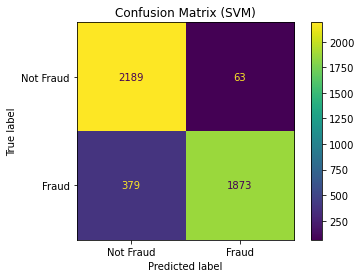

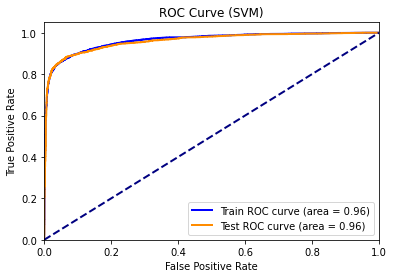

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amt', 'trans_day',
                                                   'trans_month', 'trans_hour',
                                                   'age_at_transaction',
                                                   'time_since_last_trans',
                                                   'avg_transaction_amount',
                                                   'category_transaction_count',
                                                   'unique_transactions_day',
                                                   'user_merchant_distance']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['category', 'state',
                                                   'city_pop_group',
                                                   'job_category'])])),
                ('classifier', SVC(C=0.1, probability=True, random_state=42))])

In [62]:
svm = run_grid_search(svm_pipeline, svm_param_grid, "SVM")
svm

# Conclusion

### Best Model: XGBoost

XGBoost:
- Has the highest precision score on the test set 
- Excellent at minimizing false positives (avoids incorrectly flagging legitimate transactions as fraudulent)
- Also has a high recall score on the test set
- Metrics:
    - Training Precision Score: 0.9985, Test Precision Score: 0.9875
    - Training Recall Score: 0.9985, Test Recall Score: 0.9858
    - Training F1 Score: 0.9985, Test F1 Score: 0.9867

In [63]:
# Save model with joblib
joblib.dump(xgboost, '../models/xgboost_model.pkl')

['../models/xgboost_model.pkl']

In [72]:
# Save dataset with joblib
train_sample.to_csv('../data/clean/model_dataset.csv', index=False)
train.to_csv('../data/clean/full_cleaned_dataset.csv', index=False)